##### Stock Market Sentiment Analysis using NLP

In [1]:
import math
import pandas as pd
import numpy as np
import pandas_datareader as web
import requests
import datetime
import seaborn as sns
import matplotlib.pyplot as plt


from datetime import datetime
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sys import argv

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

plt.style.use('fivethirtyeight') 

Using TensorFlow backend.


##### Web scarping and geting the news headlines for a specific Index and create the first dataframe for the analysis

In [29]:
##### Parse the data
source_url = 'https://www.finviz.com/quote.ashx?t='
source_tickers = ['NDAQ']# Or 'NDAQ'

##### Create a dictionary which has all the tables from the view source page from tickers' html
headlines_tables = {}
for ticker in source_tickers:
    url = source_url + ticker
    request = Request(url = url, headers = {'user-agent':'my-app'})
    response = urlopen(request)
    
    html = BeautifulSoup(response, 'html')
    headline_table = html.find(id = 'news-table')
    headlines_tables[ticker] = headline_table
    #break
# print(news_tables)

In [30]:
##### Creating a dataframe using the headlines
parsed_data = []
for ticker, headline_table in headlines_tables.items():
    for row in headline_table.findAll('tr'):
        title = row.a.text
        date_data = row.td.text.split(' ')
        
        ##### Storing Time and Date as two columns separately        
        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]
        parsed_data.append([ticker,date,time,title])
# parsed_data


##### Creating a dataframe from the parsed data. Sentiment analysis using nltk
data = pd.DataFrame(parsed_data, columns = ['Ticker', 'Date', 'Time', 'Headlines'])

In [31]:
##### Combing the daily news headlines for a specific ticker 
def headline(date): 
    headline = []
    headline.append(' '.join(x for x in data.Headlines[data.Date == date]))
    return str(headline)


##### List of all daily news for a specific ticker
Headlines = []
for date in data.Date.unique():
    np.asarray(Headlines.append(headline(date)))
# Headlines


##### Create a Dataframe for the analysis
d = {'Date':data.Date.unique(),'Headlines':Headlines}
df1 = pd.DataFrame(d)

In [32]:
##### Replacing Punctuations with space
df1['Headlines'].replace("[^a-zA-Z]", " ", regex = True, inplace = True)


##### Making the Headlines to lower case
df1['Headlines'] = df1['Headlines'].str.lower()


##### Find Subjectivity and Polarity scores of news using TextBolb
Subjectivity = []
Polarity = []
for headlines in df1['Headlines']:
    blob = TextBlob(headlines)
    Subjectivity.append(blob.sentiment.subjectivity/len(blob))
    Polarity.append(blob.sentiment.polarity/len(blob))
df1['Subjectivity'] = Subjectivity
df1['Polarity'] = Polarity


##### Find Subjectivity and Polarity scores of news using VADER
vader = SentimentIntensityAnalyzer()
f = lambda title: vader.polarity_scores(title)['compound']
df1['Compound'] = df1['Headlines'].apply(f)

##### Getting the price quote for the Index and create the second dataframe for the analysis

In [33]:
##### Get the stock quote from yahoo. 
finance_tickers = ['^IXIC'] # '^IXIC'
df2 = web.DataReader(finance_tickers[0], data_source = 'yahoo', start = '1980-01-01', end = '2020-08-03')


##### Adding a Change column showing the daily increase/decrease amount on the stock price 
Change = []
for i in range(0,df2.shape[0]):
    Change.append(df2.Close[i] - df2.Open[i])
df2['Change'] = Change


##### Changing the index   
df2['Date'] = df2.index # Making the index "Date" as a column of the dataframe.
df2['Index'] = [i for i in range(df2.shape[0])] # Creating an index column and remove the Date as index
df2 = df2.set_index('Index')


##### Changing the format of date
new_date = []
for date in df2.Date:
     new_date.append(datetime.strftime(datetime.strptime(str(date)[0:10], '%Y-%m-%d'),'%b-%d-%y'))
df2['Date'] = new_date
df2.head()

,High,Low,Open,Close,Volume,Adj Close,Change,Date
Index,,,,,,,,
0,148.169998,148.169998,148.169998,148.169998,0,148.169998,0.0,Jan-02-80
1,145.970001,145.970001,145.970001,145.970001,0,145.970001,0.0,Jan-03-80
2,148.020004,148.020004,148.020004,148.020004,0,148.020004,0.0,Jan-04-80
3,148.619995,148.619995,148.619995,148.619995,0,148.619995,0.0,Jan-07-80
4,150.679993,150.679993,150.679993,150.679993,0,150.679993,0.0,Jan-08-80


Merging two dataframes df1 and df2

In [34]:
##### Merging the data set on the date field
df = df1.merge(df2, how = 'inner', on = 'Date', left_index = True)

##### Data Cleaning, pre-processing 
df['Headlines'].replace("[^a-zA-Z]", " ",regex = True, inplace = True) # Replacing Punctuations with space
df['Headlines'] = df['Headlines'].str.lower() # Making the Headlines to lower case


##### Find Subjectivity and Polarity scores of news using TextBolb
Subjectivity = []
Polarity = []
for news in df['Headlines']:
    blob = TextBlob(news)
    Subjectivity.append(blob.sentiment.subjectivity/len(blob))
    Polarity.append(blob.sentiment.polarity/len(blob))
df['Subjectivity'] = Subjectivity
df['Polarity'] = Polarity


##### Find Subjectivity and Polarity scores of news using VADER
vader = SentimentIntensityAnalyzer()
# Example: print(vader.polarity_scores("I think Apple is a bad company. I think they will fail this season."))
f = lambda title: vader.polarity_scores(title)['compound']
df['Compound'] = df['Headlines'].apply(f)

In [35]:
##### Creating a label (1) when there is an increase in the price and the compound score is positive; Label (0) otherwise.
Label = []
for (x,y) in zip(df['Change'],df['Compound']):
    if x > 0 and y > 0:
        Label.append(1)
    else:
        Label.append(0)
df['Label'] = Label

In [36]:
##### Filtering the data frame df
df = df.filter(['Date', 'Label', 'Headlines', 'Close', 'Change', 'Compound'])
df.head()

,Date,Label,Headlines,Close,Change,Compound
Index,,,,,,
10234,Aug-03-20,0,delisting of class a common stock units and...,10902.799805,54.160156,0.0000
10233,Jul-31-20,0,tradeweb selects nasdaq to provide market su...,10745.269531,3.799805,0.0000
10230,Jul-28-20,0,nasdaq reports huge jump in earnings per sha...,10402.089844,-107.110352,0.5423
10228,Jul-24-20,1,nasdaq announces mid month open short intere...,10363.179688,68.769531,0.4588
10227,Jul-23-20,0,singapores vision to xa attract tech listing...,10461.419922,-228.080078,0.3612


In [37]:
# First convert the date from string to a normal format with hierarchy 
df['Date'] = pd.to_datetime(df.Date).dt.date

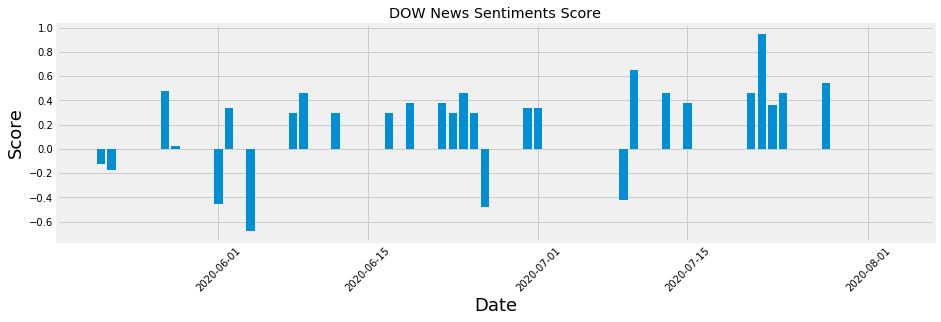

In [38]:
##### Visualization of Sentiment Scores/Trend over time.
plt.figure(figsize = (14,4))
plt.title('{var_name} News Sentiments Score'.format(var_name='DOW'))
plt.bar(df['Date'], df['Compound'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Score',fontsize = 18)
plt.xticks(rotation=45)
plt.show()

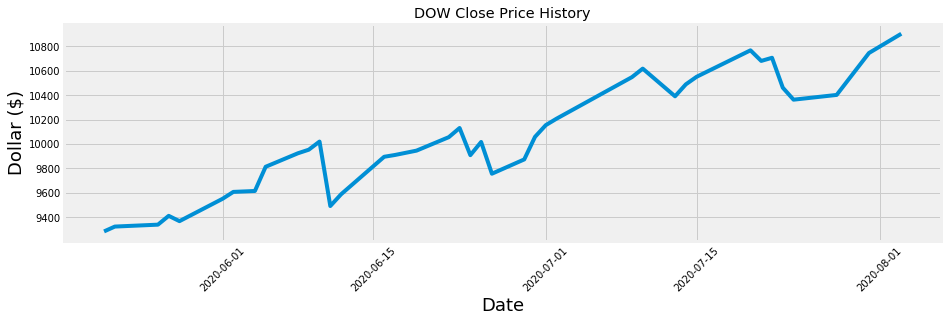

In [39]:
##### Visualization of Close Price History
plt.figure(figsize = (14,4))
plt.title('{var_name} Close Price History'.format(var_name='DOW'))
plt.plot(df['Date'], df['Close'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Dollar ($)',fontsize = 18)
plt.xticks(rotation=45)
plt.show()

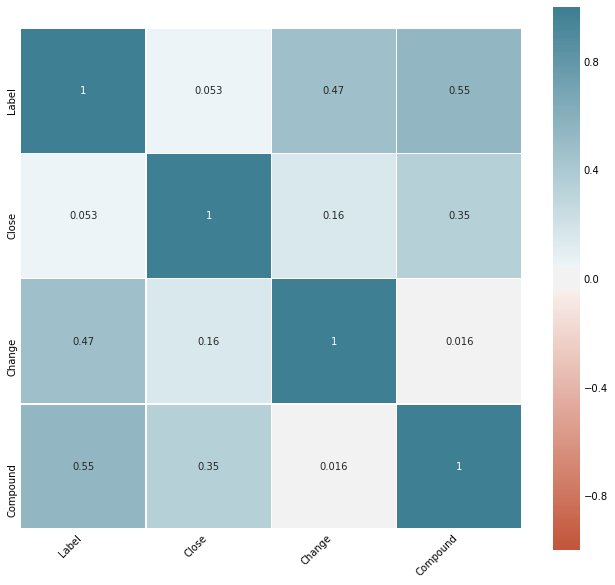

In [48]:
##### Heatmap of feature correlation
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(corr,vmin=-1,vmax=1,center=0,cmap=sns.diverging_palette(20,220,n=2000),square=True, annot=True,linewidths=.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')
plt.show()

##### Developing a predictive model using RNN LSTM

In [49]:
##### Create a new dataframe with only the 'Close' Column
df_close = df2.filter(['Close'])
df_close_ = df_close.values # Convert the dataframe to a numpy array


##### Scaling the data 
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(df_close_)


##### Create the training data set: %80-%20 Train-Test
train_len = math.ceil(len(df_close_)*0.8)
train_data = scaled_data[0:train_len, :]
x_train = []
y_train = []
last = 100 # Train our model using the last l days of data. 
for i in range(last,train_len):
    x_train.append(train_data[i-last:i,0])
    y_train.append(train_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train) # Convert to numpy arrays

##### Build the RRN-LSTM modol

In [50]:
##### Reshape the data for LSTM 
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

##### Structure of RRN-LSTM
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50,return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

##### Compile and train the model
model.compile(optimizer = 'adam', loss ='mean_squared_error')
model.fit(x_train,y_train, batch_size = 1, epochs=1)

Epoch 1/1
8088/8088 [==============================] - 415s 51ms/step - loss: 9.9477e-05


In [52]:
##### Create the testing data set
test_data = scaled_data[train_len-last:,:]# or scaled_data[train_len-60:len(df_close),:]
x_test = []
y_test = df_close_[train_len: , :]

for i in range(last,len(test_data)):
    x_test.append(test_data[i-last:i,0])
    
x_test = np.array(x_test) # Covert to a numpy array
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1)) # Reshape the data

In [53]:
##### Get the model presictions for y_test
predictions = model.predict(x_test)


##### Invert the scaling 
predictions = scaler.inverse_transform(predictions)

In [54]:
##### Evaluate the model performance by Root Mean Squared Error
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print(rmse)

280.18724786845075


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


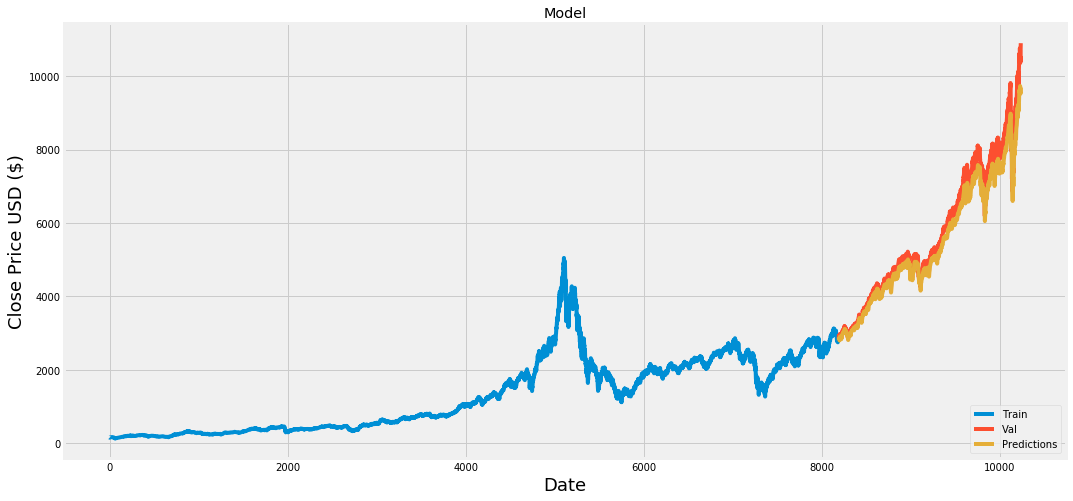

In [55]:
##### Plot the data
train = df_close[:train_len]
valid = df_close[train_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize = (16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)',fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.show()

##### See how the model predict! It doesn't do very well with Index. But for Stock Somehow the prediction is Ok.

In [57]:
##### Get the predicated quote
pred_quote = web.DataReader('^IXIC', data_source = 'yahoo', start = '2012-01-01', end = '2020-08-04')
new_df = pred_quote.filter(['Close'])
last_days = new_df[-last:].values # last n days closing price values; n=5
last_days_scaled = scaler.transform(last_days) # Scaling 


X_test = []
X_test.append(last_days_scaled) # Append the last n days
X_test = np.array(X_test) # Convert to a numpy array
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1)) # Reshape the data
pred_price = model.predict(X_test) # Get the predicated scaled price
pred_price = scaler.inverse_transform(pred_price) # Reverse the scaling
print(pred_price)

[[9892.2705]]


In [58]:
##### Get the actual quote
actual_quote = web.DataReader('^IXIC', data_source = 'yahoo', start = '2020-08-05', end = '2020-08-05')
print(actual_quote)

                    High           Low          Open         Close  \
Date                                                                 
2020-08-05  11002.110352  10943.719727  10967.870117  10998.400391   

                Volume     Adj Close  
Date                                  
2020-08-05  4119550000  10998.400391  
